<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/Chest-Xray-Pneumonia-Img-Classification-VGG16-Tuned/Chest_X_Ray_Images_Vgg16_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Data source import complete.


# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix

# Configs

In [ ]:
class Config:
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 10
    BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"

config = Config()

*Define Paths*

In [ ]:
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")
VAL_DIR = os.path.join(BASE_DIR, "val")

# Load Data

* Challenge: X-Ray images are black and white (1 channel), but VGG16 is trained on ImageNet (3 channel color).
* Solution: We need to copy the 1 channel image 3 times to make it look like RGB.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=config.IMG_SIZE,
    batch_size=config.BATCH_SIZE,
    color_mode="rgb",
    label_mode="binary" # Output-> 0 or 1
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=config.IMG_SIZE,
    batch_size=config.BATCH_SIZE,
    color_mode="rgb",
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=config.IMG_SIZE,
    batch_size=config.BATCH_SIZE,
    color_mode="rgb",
    label_mode="binary",
    shuffle=False
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


*Optimization*

In [ ]:
# Define autotune
AUTOTUNE = tf.data.AUTOTUNE

# train data
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# Handling Data Imbalance

In [ ]:
normal_count = len(os.listdir(os.path.join(TRAIN_DIR, "NORMAL")))
pneumonia_count = len(os.listdir(os.path.join(TRAIN_DIR, "PNEUMONIA")))
total_count = normal_count + pneumonia_count
print(f"Normal: {normal_count}, Pneumonia: {pneumonia_count}")

Normal: 1341, Pneumonia: 3875


*Calculattion*

In [ ]:
weight_for_0 = (1 / normal_count) * (total_count / 2.0)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"Calculated weights: Normal: {weight_for_0:.2f}, Pneumonia: {weight_for_1:.2f}")

Calculated weights: Normal: 1.94, Pneumonia: 0.67


# Loading `VGG16`

In [ ]:
# Download base model
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=config.IMG_SIZE + (3,)
)

# freezing base_model
base_model.trainable = False

# Adding new heads
inputs = tf.keras.Input(shape=config.IMG_SIZE + (3,))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")]
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [ ]:
# Define callbacks

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_xray_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True),
]

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 382ms/step - accuracy: 0.6349 - loss: 1.2517 - recall: 0.6079 - val_accuracy: 0.9415 - val_loss: 0.1618 - val_recall: 0.9506
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.8920 - loss: 0.3268 - recall: 0.8900 - val_accuracy: 0.9482 - val_loss: 0.1615 - val_recall: 0.9444
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.9143 - loss: 0.2324 - recall: 0.9123 - val_accuracy: 0.9588 - val_loss: 0.1371 - val_recall: 0.9580
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - accuracy: 0.9248 - loss: 0.2125 - recall: 0.9236 - val_accuracy: 0.9626 - val_loss: 0.1074 - val_recall: 0.9630
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.9344 - loss: 0.1769 - recall: 0.9329 - val_accuracy: 0.9569 - val_loss: 0.1308 - val_recall: 0.9519
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.9384 - loss: 0.1699 - recall: 0.9353 - val_accuracy: 0.9626 - val_loss: 0.1083 - val_

# Evaluation

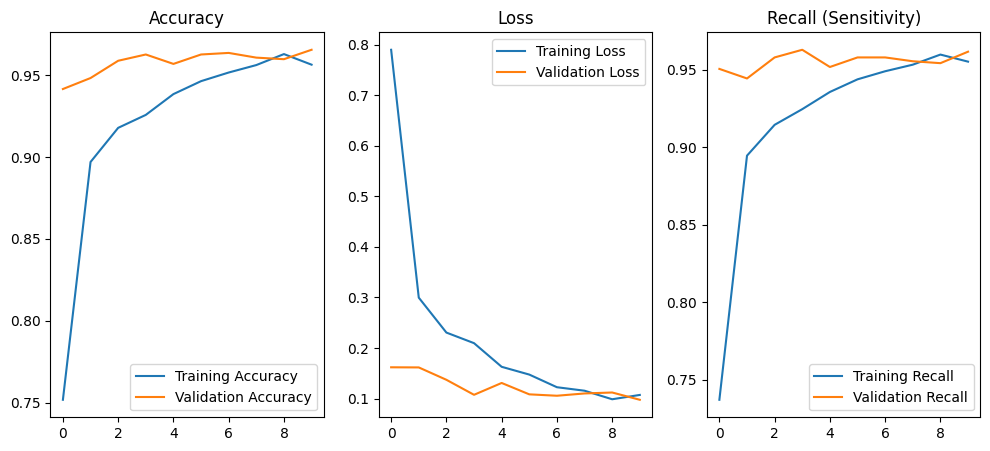

In [ ]:
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.subplot(1, 3, 3)
    plt.plot(recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.title('Recall (Sensitivity)')
    plt.show()

plot_history(history)

*Evaluation on `test_ds`*

In [ ]:
loss, acc, recall = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.2%}")
print(f"Test Recall: {recall:.2%}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 620ms/step - accuracy: 0.7218 - loss: 0.7518 - recall: 0.6487
Test Accuracy: 83.65%
Test Recall: 98.21%


In [ ]:
# Confusion Matrix
y_true = []
y_pred = []

for img, label in test_ds:
    pred = model.predict(img, verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend((pred > 0.5).astype(int)) # تبدیل احتمال به 0 و 1

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


Confusion Matrix:
[[139  95]
 [  7 383]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.59      0.73       234
   Pneumonia       0.80      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.88      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



*Change Threshold*

In [ ]:
full_preds = model.predict(test_ds)
full_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Set threshold
threshold = 0.70
y_pred_new = (full_preds > threshold).astype(int)

print(f"--- Results with Threshold {threshold} ---")
print("\nConfusion Matrix:")
print(confusion_matrix(full_labels, y_pred_new))

print("\nClassification Report:")
print(classification_report(full_labels, y_pred_new, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step
--- Results with Threshold 0.7 ---

Confusion Matrix:
[[164  70]
 [ 14 376]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.70      0.80       234
   Pneumonia       0.84      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.83      0.85       624
weighted avg       0.87      0.87      0.86       624

